***IMPORTING REQUIRED LIBRARIES***

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

**SELECTING GPU OR CPU FOR COMPUTATIONS**

In [2]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

***transformes for grey scale images***

**```transforms.ToTensor()``` to convert into pytorch tensors**

**```transforms.Normalize((0.5,),(0.5))``` is to normalize**

**for RGB the parameters vary as ```transformed.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))```**

**transformes are applied only when DataLoader is applied**

In [3]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5))])

### ```torchvision.datasets``` to download mnist dataset ###

In [4]:
train_ds = torchvision.datasets.MNIST('mnist',train=True,transform=transform,download=True)
test_ds = torchvision.datasets.MNIST('mnist',train=False,transform=transform,download=True)

In [5]:
print(train_ds.data.shape)   #no of images in training dataset and size of each image
print(test_ds.data.shape)    #no of images in testing dataset and size of each image

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


In [6]:
print(train_ds.data[0])   #not normalized btw -1 and 1

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

### functions to display images ###

In [7]:
import cv2
import matplotlib.pyplot as plt
def img_show(title = '',image = None, size = 2):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(aspect_ratio*size,size))
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.title = title
    plt.show()

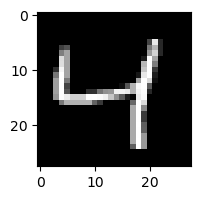

In [8]:
img_show('mnist',train_ds.data[2].numpy())

###   displaying first 50 images ###

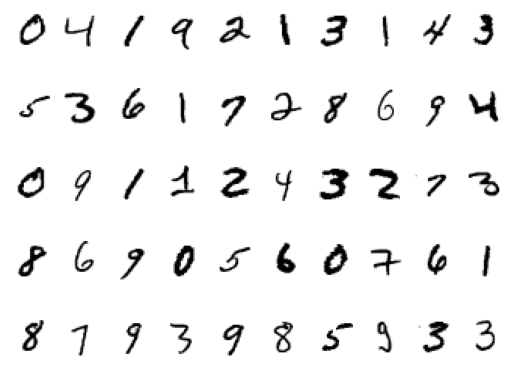

In [9]:

fig = plt.figure()
no_images = 50 

for i in range(1, no_images + 1):
    plt.subplot(5, 10, i)
    plt.axis('off')
    plt.imshow(train_ds.data[i], cmap='gray_r')

***DATA LOADER***

**these are used to set our data in specified batch size**

In [10]:
train_loader = torch.utils.data.DataLoader(train_ds,batch_size = 128,shuffle = True,num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=128,shuffle=True,num_workers=0)

***LOADING BATCHES***

In [11]:
"""train_iter = iter(train_loader)
images,labels = next(train_iter)
print(images.shape)
print(labels.shape)""" 

'train_iter = iter(train_loader)\nimages,labels = next(train_iter)\nprint(images.shape)\nprint(labels.shape)'

### ***MODEL BUILDING*** ###
**using nn.Sequential() method for building model**

In [12]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()

        self.conv1 = nn.Conv2d(1,32,3)
        self.conv2 = nn.Conv2d(32,64,3)
        self.maxpool = nn.MaxPool2d(2,2)
        self.full1 = nn.Linear(64*12*12,128)
        self.full2 = nn.Linear(128,10)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(-1,64*12*12)
        x = F.relu(self.full1(x))
        x = self.full2(x)
        return x
    
net = Net()
net.to(device)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (full1): Linear(in_features=9216, out_features=128, bias=True)
  (full2): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr = 0.001,momentum=0.9)

In [14]:
epochs = 10
epoch_log = []
accuracy_log = []
loss_log = []
for epoch in range(epochs):
    print(f'starting epoch:{epoch+1}')

    running_loss = 0.0
    for i,data in enumerate(train_loader,0):
        inputs , labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            correct = 0
            total = 0

            with torch.no_grad():
                for images,labels in test_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, dim = 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                accuracy  = 100*correct/total
                epoch_no = epoch+1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_no}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0
    epoch_log.append(epoch_no)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')

starting epoch:1
Epoch: 1, Mini-Batches Completed: 50, Loss: 2.265, Test Accuracy = 51.530%
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.095, Test Accuracy = 65.980%
Epoch: 1, Mini-Batches Completed: 150, Loss: 1.627, Test Accuracy = 73.440%
Epoch: 1, Mini-Batches Completed: 200, Loss: 0.928, Test Accuracy = 83.240%
Epoch: 1, Mini-Batches Completed: 250, Loss: 0.593, Test Accuracy = 86.370%
Epoch: 1, Mini-Batches Completed: 300, Loss: 0.479, Test Accuracy = 87.990%
Epoch: 1, Mini-Batches Completed: 350, Loss: 0.419, Test Accuracy = 89.500%
Epoch: 1, Mini-Batches Completed: 400, Loss: 0.393, Test Accuracy = 89.910%
Epoch: 1, Mini-Batches Completed: 450, Loss: 0.379, Test Accuracy = 89.880%
starting epoch:2
Epoch: 2, Mini-Batches Completed: 50, Loss: 0.336, Test Accuracy = 90.760%
Epoch: 2, Mini-Batches Completed: 100, Loss: 0.338, Test Accuracy = 90.810%
Epoch: 2, Mini-Batches Completed: 150, Loss: 0.328, Test Accuracy = 91.040%
Epoch: 2, Mini-Batches Completed: 200, Loss: 0.307, Test

***SAVING OUR MODEL***

In [15]:
PATH = './hand_written_cnn_net.pth'
torch.save(net.state_dict(), PATH)

In [16]:
net = Net()
net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
test_iter = iter(test_loader)
images, labels = next(test_iter)
images = images.to(device)
labels = labels.to(device)

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ''.join('%1s' % predicted[j].cpu().numpy() for j in range(128)))

Predicted:  79493999441762218850506606497597780950592644031447245801541734569781867601231582230400506363054670191222535639843798348747882002


In [18]:
correct = 0 
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # Move our data to GPU
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the test data: {accuracy:.3}%')

Accuracy of the network on the test data: 98.0%


***visualizing logs***

In [19]:
print(epoch_log)
print(accuracy_log)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[89.88, 92.69, 94.62, 95.72, 96.55, 97.06, 97.48, 97.85, 97.76, 98.07]


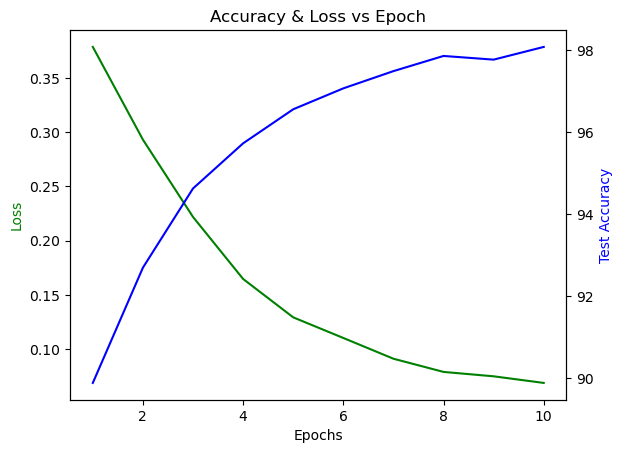

In [22]:
from importlib import reload
plt=reload(plt)
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch")
ax2 = ax1.twinx()
ax1.plot(epoch_log, loss_log,'g-')
ax2.plot(epoch_log, accuracy_log,'b-')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()